# Diabetes Dataset - EDA

## Opening and First look

In [91]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
dataset = pd.read_csv('../diabetes_unclean.csv')

In [93]:
dataset

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26.0,4.5,62.0,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33.0,7.1,46.0,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,191,454316,M,55.0,NaN,62.0,6.8,5.3,2.0,1.0,3.5,0.9,30.1,Y
1005,192,454316,M,55.0,4.8,88.0,NaN,5.7,4.0,0.9,3.3,1.8,30.0,Y
1006,193,454316,M,62.0,6.3,82.0,6.7,5.3,2.0,1.0,3.5,NaN,30.1,Y
1007,194,454316,F,57.0,4.1,70.0,9.3,5.3,3.3,1.0,1.4,1.3,29.0,Y


In [94]:
print(dataset.columns.values)

['ID' 'No_Pation' 'Gender' 'AGE' 'Urea' 'Cr' 'HbA1c' 'Chol' 'TG' 'HDL'
 'LDL' 'VLDL' 'BMI' 'CLASS']


## Dataset features
In the dataset we can access the following feature:

- **Gender**: The gender of the individual (e.g., Male, Female).

- **AGE**: The age of the individual in years.

- **Urea**: The level of urea in the blood, indicating kidney function. 

- **Cr**: Creatinine level in the blood, used to assess kidney function.


- **HbA1c**: Hemoglobin A1c percentage, a measure of average blood sugar levels over the past 2-3 months.

- **Chol**: Total cholesterol level in the blood, measured in mg/dL, indicating lipid profile.

- **TG**: Triglycerides level in the blood, measured in mg/dL, another component of the lipid profile.

- **HDL**: High-Density Lipoprotein cholesterol, often referred to as "good cholesterol," measured in mg/dL.

- **LDL**: Low-Density Lipoprotein cholesterol, often referred to as "bad cholesterol," measured in mg/dL.

- **VLDL**: Very Low-Density Lipoprotein cholesterol, another type of "bad cholesterol," measured in mg/dL.

- **BMI**: Body Mass Index, a measure of body fat based on height and weight.

- **CLASS**: The target variable indicating the presence or absence of diabetes (e.g., diabetic or non-diabetic).


In [95]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1009 non-null   int64  
 1   No_Pation  1009 non-null   int64  
 2   Gender     1009 non-null   object 
 3   AGE        1008 non-null   float64
 4   Urea       1008 non-null   float64
 5   Cr         1007 non-null   float64
 6   HbA1c      1006 non-null   float64
 7   Chol       1007 non-null   float64
 8   TG         1007 non-null   float64
 9   HDL        1008 non-null   float64
 10  LDL        1007 non-null   float64
 11  VLDL       1008 non-null   float64
 12  BMI        1009 non-null   float64
 13  CLASS      1009 non-null   object 
dtypes: float64(10), int64(2), object(2)
memory usage: 110.5+ KB


In [96]:
dataset.describe()

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1009.000000,1.009000e+03,1008.000000,1008.000000,1007.000000,1006.000000,1007.000000,1007.000000,1008.000000,1007.000000,1008.000000,1009.000000
mean,339.161546,2.717448e+05,53.620040,5.131094,68.973188,8.284155,4.863873,2.348769,1.204216,2.610119,1.850595,29.589911
std,239.738169,3.365681e+06,8.740975,2.931136,59.813297,2.533576,1.297326,1.397487,0.658158,1.116095,3.649859,4.946246
min,1.000000,1.230000e+02,25.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,127.000000,2.406500e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,296.000000,3.439900e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,548.000000,4.539000e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


# Data Cleaning and Preprocessing
- Backup the original dataset
- Check for Null values
- Conversion to numerical values or one-hot encoding of the 'object' or 'string' types
- Check for outliers 

In [97]:
ds_backup = dataset.copy()
ds_backup.to_csv('diabetes_unclean_backup.csv', index=False)

In [98]:
dataset.isnull().sum()

ID           0
No_Pation    0
Gender       0
AGE          1
Urea         1
Cr           2
HbA1c        3
Chol         2
TG           2
HDL          1
LDL          2
VLDL         1
BMI          0
CLASS        0
dtype: int64

### Null values 
Since the total entries of the dataset are 1009 and the Null values are around the 2% of the dataset it is possible to remove them (no fill required)


In [99]:
dataset.dropna(inplace=True)

### Conversion to numerical values

In [100]:
dataset.dtypes

ID             int64
No_Pation      int64
Gender        object
AGE          float64
Urea         float64
Cr           float64
HbA1c        float64
Chol         float64
TG           float64
HDL          float64
LDL          float64
VLDL         float64
BMI          float64
CLASS         object
dtype: object

Columns to be converted or encoded:
- Gender -> simple encoding [0 = 'M', 1 = 'F']
- Class -> simple encoding [0 = non-positive, 1 = positive]


In [101]:
dataset['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

As there are inconsistencies in the gender column we will perform a 'normalization' of the data and a conversion to numeric value 
```
[0: Male, 1: Female]
```

In [102]:
# Repairing inconcistent values and Encoding of the 'Gender' column
dataset['Gender'] = dataset['Gender'].str.upper().map({'M': 0, 'F': 1})

In [103]:
dataset['CLASS'].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

As we can see there are several unique values with inconsistent syntax, since the possible value of the column `CLASS` are 'Diabetic' or 'Not Diabetic' we will encode it with the following syntax:
```
[Positive to diabetes: 1]
[Negative to diabetes: 0]
```

In [104]:
# Encoding of the 'CLASS' column
# 1st: remove unwanted spaces
dataset['CLASS'] = dataset['CLASS'].str.strip()
# 2nd: raise all values to upper case
dataset['CLASS'] = dataset['CLASS'].str.upper()
# 3rd: make the values consistent (e.g. P means positive as well as Y, instead, N means negative or simply No)
dataset['CLASS'] = dataset['CLASS'].replace({'P': 'Y'})

# check:
# dataset['CLASS'].unique()

# 4th: Encoding of the 'CLASS' column
dataset['CLASS'] = dataset['CLASS'].map({'Y': 1, 'N': 0})

### Unused columns
Some columns are not relevant to predict diabetes. For example, columns like `ID` and `No_Pation` do not provide meaningful information for prediction and can be removed.

In [105]:
# removing unused columns
# backup of the cleaned and encoded dataset
ds_backup = dataset.copy()
ds_backup.to_csv('diabetes_cleaned.csv', index=False)
# removing unused columns
dataset.drop(columns=['ID', 'No_Pation'], inplace=True)


### Search for outliers

In [106]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,994.0,0.434608,0.495955,0.0,0.00,0.0,1.0,1.00
AGE,994.0,53.605634,8.758101,25.0,51.00,55.0,59.0,79.00
Urea,994.0,5.129520,2.948246,0.5,3.67,4.6,5.7,38.90
Cr,994.0,68.742455,60.087902,6.0,48.00,60.0,73.0,800.00
HbA1c,994.0,8.286378,2.542578,0.9,6.50,8.0,10.2,16.00
Chol,994.0,4.859678,1.299625,0.0,4.00,4.8,5.6,10.30
TG,994.0,2.343471,1.399343,0.3,1.50,2.0,2.9,13.80
HDL,994.0,1.206187,0.662212,0.2,0.90,1.1,1.3,9.90
LDL,994.0,2.610151,1.116133,0.3,1.80,2.5,3.3,9.90
VLDL,994.0,1.859054,3.674106,0.1,0.70,0.9,1.5,35.00


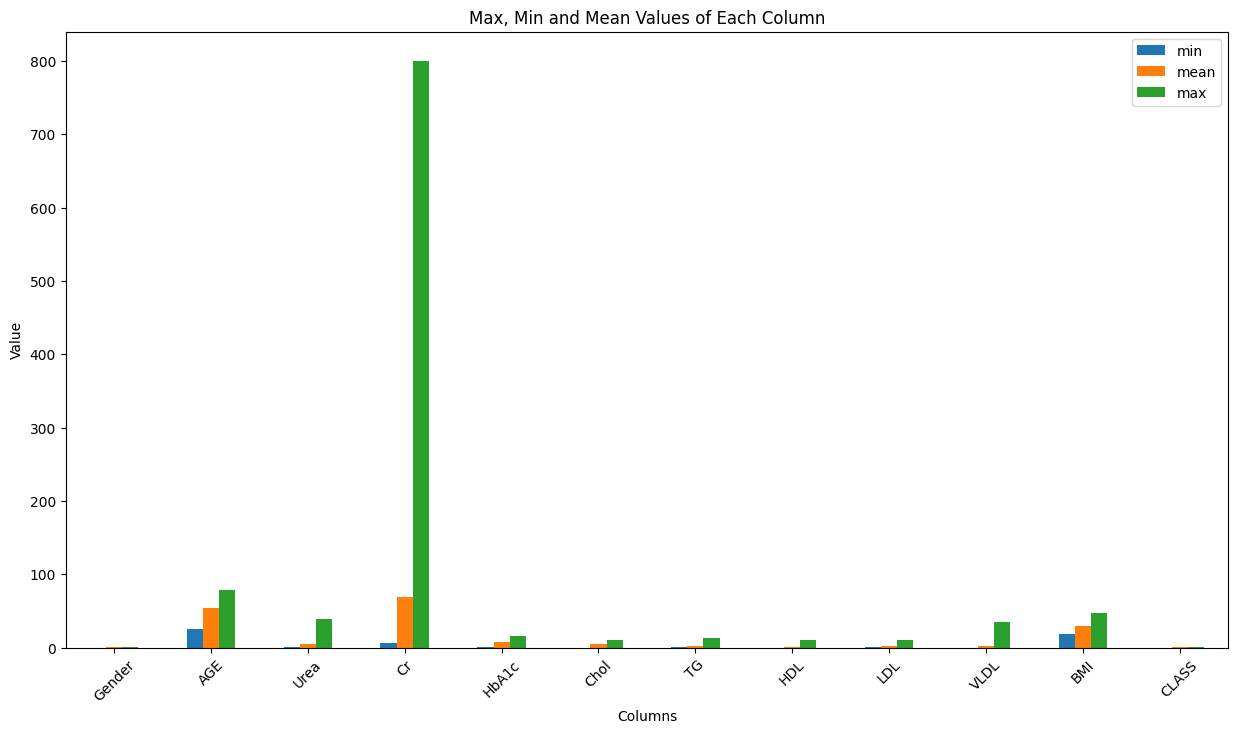

In [107]:
# Plot max, mean, and min values for each column
stats = dataset.describe().T
stats[['min', 'mean', 'max']].plot(kind='bar', figsize=(15, 8))
plt.title('Max, Min and Mean Values of Each Column')
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Value')
plt.show()


As shown in the graph above, there is an outlier in the 'Cr' columns.

The usual reference range of serum creatinine is:
```
60 to 110 micromol/L (0.7 to 1.2 mg/dL) for men
45 to 90 micromol/L (0.5 to 1.0 mg/dL) for women.
````

We will consider values higher than 320 as outliers, as they are significantly above the usual reference range and could indicate potential data entry errors or remote and extreme cases.

Source: [BMJ Best Practice - Acute kidney injury](https://bestpractice.bmj.com/topics/en-gb/935)



In [108]:
# Detect the outliers in the `Cr`column
outliers = dataset[dataset['Cr'] > 320]

# remove the outliers and clean the dataset
dataset.drop(outliers.index, inplace=True)

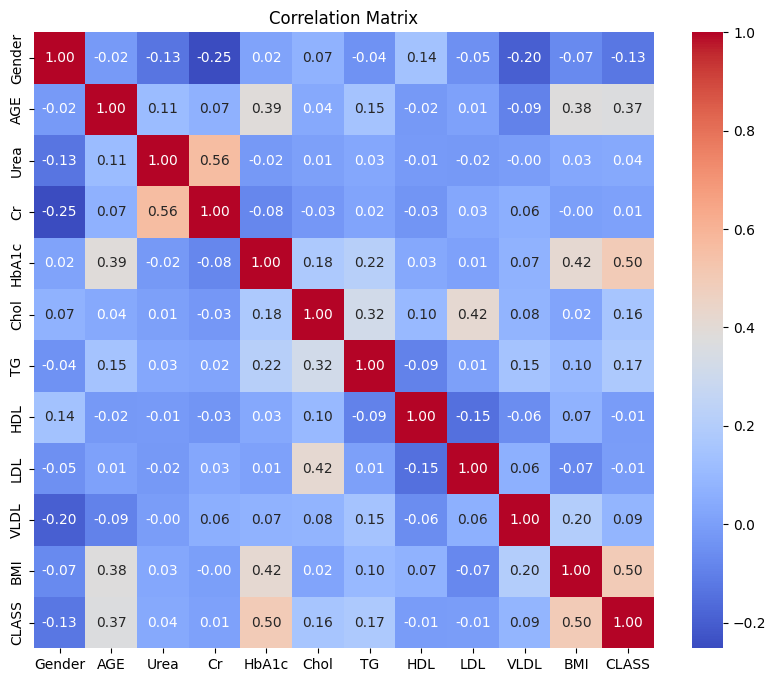

In [109]:
# plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()